--- Starting Setup ---
Using device: cuda

Input image found at: /kaggle/input/cv-homework-3/sample_image_Q1_Q2.jpg
--- Setup Complete ---

--- Installing/Verifying Dependencies (transformers, Pillow) ---
Dependencies (transformers, Pillow) installed/verified successfully.


2025-04-20 08:40:12.007037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745138412.210140      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745138412.269038      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



--- Loading BLIP VQA model: Salesforce/blip-vqa-base ---


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

BLIP VQA model and processor loaded successfully.

--- Loading and Displaying Image ---
Successfully loaded image from: /kaggle/input/cv-homework-3/sample_image_Q1_Q2.jpg


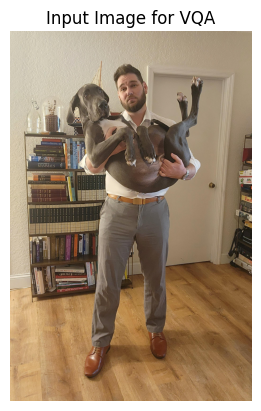


--- Performing Visual Question Answering ---

Generating answers...
------------------------------
Question: Where is the dog present in the image?
Answer:   in man ' s arms
------------------------------
Question: Where is the man present in the image?
Answer:   living room

--- VQA Finished ---


--- Comments on VQA Results ---

Summary of Questions and Generated Answers:
Q: Where is the dog present in the image?
A: in man ' s arms

Q: Where is the man present in the image?
A: living room



In [1]:
print("--- Starting Setup ---")
import torch
import os
import sys
import warnings
from PIL import Image
import matplotlib.pyplot as plt # For displaying image
import subprocess # To run shell commands like pip

# Suppress unnecessary warnings
warnings.filterwarnings("ignore")

# --- Configuration ---
# Input Image Path (Fixed as per requirement)
IMAGE_PATH = "/kaggle/input/cv-homework-3/sample_image_Q1_Q2.jpg"

# BLIP Model for Visual Question Answering (Base version is usually sufficient)
VQA_MODEL_NAME = "Salesforce/blip-vqa-base"
# Alternative if base is not good enough: "Salesforce/blip-vqa-capfilt-large"

# Questions to ask
questions = [
    "Where is the dog present in the image?",
    "Where is the man present in the image?"
]

# --- Device Setup ---
# Ensure GPU is enabled in Notebook settings (Accelerator -> GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cpu":
    print("Warning: Running on CPU. Computations might be slow. Consider enabling GPU.")

# --- Path Existence Check for Input Image ---
image_exists = os.path.exists(IMAGE_PATH)
if not image_exists:
    print(f"\nError: Input image not found at '{IMAGE_PATH}'.")
    print("Please ensure the Kaggle input data source 'cv-homework-3' is correctly added.")
    assert False, "Input image path invalid."
else:
    print(f"\nInput image found at: {IMAGE_PATH}")

print("--- Setup Complete ---")


print("\n--- Installing/Verifying Dependencies (transformers, Pillow) ---")
try:
    # Install transformers and Pillow (torch should be pre-installed on Kaggle GPU envs)
    subprocess.run([sys.executable, "-m", "pip", "install", "transformers", "Pillow", "--quiet"], check=True)
    print("Dependencies (transformers, Pillow) installed/verified successfully.")
    # Import necessary libraries after installation
    from transformers import BlipProcessor, BlipForQuestionAnswering
except subprocess.CalledProcessError as e:
    print(f"Error installing dependencies: {e}")
    print("Please check internet connectivity in notebook settings.")
    assert False, "Dependency installation failed."
except ImportError as e:
    print(f"Error importing libraries after attempting installation: {e}")
    assert False, "Dependency import failed."


print(f"\n--- Loading BLIP VQA model: {VQA_MODEL_NAME} ---")
vqa_processor = None
vqa_model = None
try:
    # Load the processor and model from Hugging Face Hub
    vqa_processor = BlipProcessor.from_pretrained(VQA_MODEL_NAME)
    vqa_model = BlipForQuestionAnswering.from_pretrained(VQA_MODEL_NAME).to(device)
    vqa_model.eval() # Set to evaluation mode
    print("BLIP VQA model and processor loaded successfully.")
except Exception as e:
    print(f"Error loading BLIP VQA model: {e}")
    print("Ensure internet is enabled in notebook settings if model isn't cached.")
    assert False, "Failed to load BLIP VQA model"


print("\n--- Loading and Displaying Image ---")
image_pil = None
try:
    # Open the image and ensure it's in RGB format, as expected by BLIP
    image_pil = Image.open(IMAGE_PATH).convert('RGB')
    print(f"Successfully loaded image from: {IMAGE_PATH}")

    # Display the image
    plt.imshow(image_pil)
    plt.title("Input Image for VQA")
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"Error: Image file not found again at {IMAGE_PATH}.")
    assert False, "Image load failed"
except Exception as e:
    print(f"Error loading or converting image: {e}")
    assert False, "Image processing failed"


print("\n--- Performing Visual Question Answering ---")
results = {}

if vqa_model and vqa_processor and image_pil: # Check if model, processor, and image loaded
    print("\nGenerating answers...")
    for question in questions:
        try:
            # Prepare the inputs for the model
            # The processor handles combining the image and the question text appropriately
            inputs = vqa_processor(images=image_pil, text=question, return_tensors="pt").to(device)

            # Generate the answer IDs
            # You might adjust max_length if needed
            generated_ids = vqa_model.generate(**inputs, max_length=50)

            # Decode the generated IDs to text
            # Use the processor's decode method
            answer = vqa_processor.decode(generated_ids[0], skip_special_tokens=True)

            # Store and print the result
            results[question] = answer
            print("-" * 30)
            print(f"Question: {question}")
            print(f"Answer:   {answer}")


        except Exception as e:
            print(f"\nError generating answer for question '{question}': {e}")
            results[question] = f"Error during generation: {e}" # Store error message

    print("\n--- VQA Finished ---")

else:
    print("BLIP VQA model/processor or image not loaded correctly. Skipping VQA.")

print("\n\n============================================")
print("--- Comments on VQA Results ---")
print("============================================")

# Print the Q&A pairs again for easy reference in comments
print("\nSummary of Questions and Generated Answers:")
for q, a in results.items():
    print(f"Q: {q}")
    print(f"A: {a}\n")
